# Setup

In [430]:
!pip install -q seaborn numpy pandas matplotlib scipy geopandas


[notice] A new release of pip available: 22.3.1 -> 23.2.1
[notice] To update, run: pip install --upgrade pip


In [437]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
from scipy.constants import convert_temperature

from tensorflow.keras import layers

pd.set_option('display.max_columns', None)
np.set_printoptions(precision=3, suppress=True)

# Importing and preprocessing the data

In [423]:
filepath = 'dbms_outpu.csv'
schema = {'percent_bleached': float, 'date': str, 'year': int,  'depth_meters': float, 'clim_SST': float, 'temperature_mean': float, 'SSTA_mean': float, 'SSTA_DHW':float, 'TSA':float, 'TSA_DHW':float, 'severity_code': str, 'latitude': float, 'longitude': float }
column_names = [ 'date', 'year', 'percent_bleached','depth_meters', 'clim_SST', 'temperature_mean', 'SSTA_mean', 'SSTA_DHW', 'TSA', 'TSA_DHW', 'severity_code', 'latitude', 'longitude']
raw_dataset = pd.read_csv(filepath, names=column_names,
                            dtype=schema, parse_dates=['date'],
                          na_values='', comment='\t',
                          sep=',', skipinitialspace=True)
raw_dataset

,date,year,percent_bleached,depth_meters,clim_SST,temperature_mean,SSTA_mean,SSTA_DHW,TSA,TSA_DHW,severity_code,latitude,longitude
0,2015-09-30,2015,78.00,4.9,299.33,299.860,0.0,8.800,-0.950,5.340,Severe (>50% Bleached),24.695650,-80.939200
1,2008-08-27,2008,42.00,6.8,301.67,299.840,0.0,0.000,-1.120,0.000,Moderate (11-50% Bleached),24.885200,-80.573440
2,2015-10-07,2015,100.00,4.0,298.32,299.650,0.0,10.590,-0.570,7.160,Severe (>50% Bleached),24.954170,-80.545800
3,2016-04-21,2016,50.00,3.0,262.15,301.284,0.0,7.304,0.754,6.304,Severe (>50% Bleached),-13.581056,47.901556
4,2016-04-19,2016,43.00,5.0,301.79,301.580,0.0,3.330,0.590,3.250,Severe (>50% Bleached),-13.558944,48.095389
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7301,2016-08-19,2016,3.42,9.9,301.47,299.730,0.0,1.300,0.950,0.000,Mild (1-10% Bleached),25.332810,-80.165050
7302,2016-09-06,2016,17.29,11.8,300.84,299.690,0.0,4.370,-0.910,1.260,Moderate (11-50% Bleached),24.466360,-82.001920
7303,2016-09-06,2016,3.41,12.2,300.84,299.730,0.0,3.140,-0.860,1.020,Mild (1-10% Bleached),24.470830,-81.971490
7304,2016-09-14,2016,7.87,5.5,299.86,299.670,0.0,1.730,0.650,1.130,Mild (1-10% Bleached),24.513850,-81.922470


In [424]:
dataset = raw_dataset.filter(['year', 'percent_bleached', 'depth_meters', 'clim_SST', 'temperature_mean', 'SSTA_mean', 'SSTA_DHW', 'TSA', 'TSA_DHW', 'severity_code', 'latitude', 'longitude'], axis=1)
dataset

,year,percent_bleached,depth_meters,clim_SST,temperature_mean,SSTA_mean,SSTA_DHW,TSA,TSA_DHW,severity_code,latitude,longitude
0,2015,78.00,4.9,299.33,299.860,0.0,8.800,-0.950,5.340,Severe (>50% Bleached),24.695650,-80.939200
1,2008,42.00,6.8,301.67,299.840,0.0,0.000,-1.120,0.000,Moderate (11-50% Bleached),24.885200,-80.573440
2,2015,100.00,4.0,298.32,299.650,0.0,10.590,-0.570,7.160,Severe (>50% Bleached),24.954170,-80.545800
3,2016,50.00,3.0,262.15,301.284,0.0,7.304,0.754,6.304,Severe (>50% Bleached),-13.581056,47.901556
4,2016,43.00,5.0,301.79,301.580,0.0,3.330,0.590,3.250,Severe (>50% Bleached),-13.558944,48.095389
...,...,...,...,...,...,...,...,...,...,...,...,...
7301,2016,3.42,9.9,301.47,299.730,0.0,1.300,0.950,0.000,Mild (1-10% Bleached),25.332810,-80.165050
7302,2016,17.29,11.8,300.84,299.690,0.0,4.370,-0.910,1.260,Moderate (11-50% Bleached),24.466360,-82.001920
7303,2016,3.41,12.2,300.84,299.730,0.0,3.140,-0.860,1.020,Mild (1-10% Bleached),24.470830,-81.971490
7304,2016,7.87,5.5,299.86,299.670,0.0,1.730,0.650,1.130,Mild (1-10% Bleached),24.513850,-81.922470


In [425]:
dataset.severity_code = dataset['severity_code'].map({'No Bleaching':0, '% unknown': 1, 'Mild (1-10% Bleached)': 1, 'Moderate (11-50% Bleached)': 2, 'Severe (>50% Bleached)': 3})

dataset

,year,percent_bleached,depth_meters,clim_SST,temperature_mean,SSTA_mean,SSTA_DHW,TSA,TSA_DHW,severity_code,latitude,longitude
0,2015,78.00,4.9,299.33,299.860,0.0,8.800,-0.950,5.340,3,24.695650,-80.939200
1,2008,42.00,6.8,301.67,299.840,0.0,0.000,-1.120,0.000,2,24.885200,-80.573440
2,2015,100.00,4.0,298.32,299.650,0.0,10.590,-0.570,7.160,3,24.954170,-80.545800
3,2016,50.00,3.0,262.15,301.284,0.0,7.304,0.754,6.304,3,-13.581056,47.901556
4,2016,43.00,5.0,301.79,301.580,0.0,3.330,0.590,3.250,3,-13.558944,48.095389
...,...,...,...,...,...,...,...,...,...,...,...,...
7301,2016,3.42,9.9,301.47,299.730,0.0,1.300,0.950,0.000,1,25.332810,-80.165050
7302,2016,17.29,11.8,300.84,299.690,0.0,4.370,-0.910,1.260,2,24.466360,-82.001920
7303,2016,3.41,12.2,300.84,299.730,0.0,3.140,-0.860,1.020,1,24.470830,-81.971490
7304,2016,7.87,5.5,299.86,299.670,0.0,1.730,0.650,1.130,1,24.513850,-81.922470


In [426]:
dataset.isna().sum()

year                0
percent_bleached    0
depth_meters        0
clim_SST            0
temperature_mean    0
SSTA_mean           0
SSTA_DHW            0
TSA                 0
TSA_DHW             0
severity_code       0
latitude            0
longitude           0
dtype: int64

In [427]:
dataset = dataset.dropna()

dataset['depth_meters'] = dataset['depth_meters'].astype(np.int64)
dataset['severity_code'] = dataset['severity_code'].astype(np.int64)
dataset['clim_SST'] = convert_temperature(dataset['clim_SST'], 'Kelvin', 'Celsius')
dataset['temperature_mean'] = convert_temperature(dataset['temperature_mean'], 'Kelvin', 'Celsius')
dataset

,year,percent_bleached,depth_meters,clim_SST,temperature_mean,SSTA_mean,SSTA_DHW,TSA,TSA_DHW,severity_code,latitude,longitude
0,2015,78.00,4,26.18,26.710,0.0,8.800,-0.950,5.340,3,24.695650,-80.939200
1,2008,42.00,6,28.52,26.690,0.0,0.000,-1.120,0.000,2,24.885200,-80.573440
2,2015,100.00,4,25.17,26.500,0.0,10.590,-0.570,7.160,3,24.954170,-80.545800
3,2016,50.00,3,-11.00,28.134,0.0,7.304,0.754,6.304,3,-13.581056,47.901556
4,2016,43.00,5,28.64,28.430,0.0,3.330,0.590,3.250,3,-13.558944,48.095389
...,...,...,...,...,...,...,...,...,...,...,...,...
7301,2016,3.42,9,28.32,26.580,0.0,1.300,0.950,0.000,1,25.332810,-80.165050
7302,2016,17.29,11,27.69,26.540,0.0,4.370,-0.910,1.260,2,24.466360,-82.001920
7303,2016,3.41,12,27.69,26.580,0.0,3.140,-0.860,1.020,1,24.470830,-81.971490
7304,2016,7.87,5,26.71,26.520,0.0,1.730,0.650,1.130,1,24.513850,-81.922470


In [428]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)


### Percent Bleached compare to Sea Surface Temperature

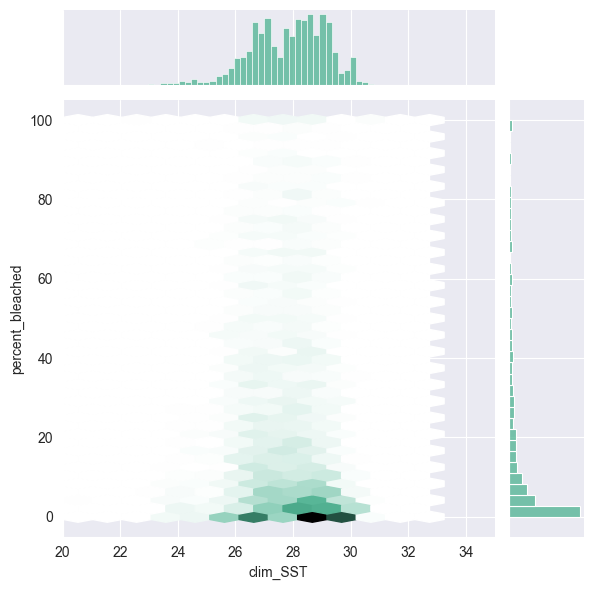

In [429]:
g = sns.jointplot(x='clim_SST', y='percent_bleached', data=train_dataset, kind="hex", color="#4CB391", xlim=(20, 35))


### Plotting the areas with temperature and coral bleaching status was reported

/var/folders/w0/_db7fdn14vlcvngdycd9f66r0000gn/T/ipykernel_66791/1175263276.py:14: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


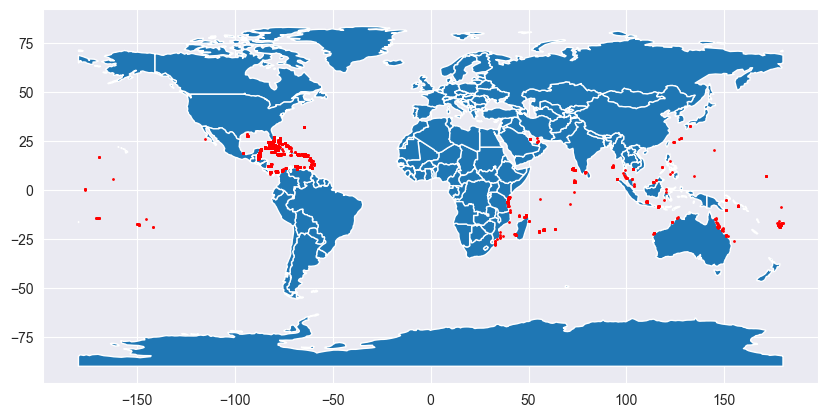

In [444]:
df = train_dataset

geometry = [Point(xy) for xy in zip(df['longitude'], df['latitude'])]
gdf = GeoDataFrame(df, geometry=geometry)   

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', color='red', markersize=1);

### Plotting the correlation between outside temperature mean and the percentage of coral bleached

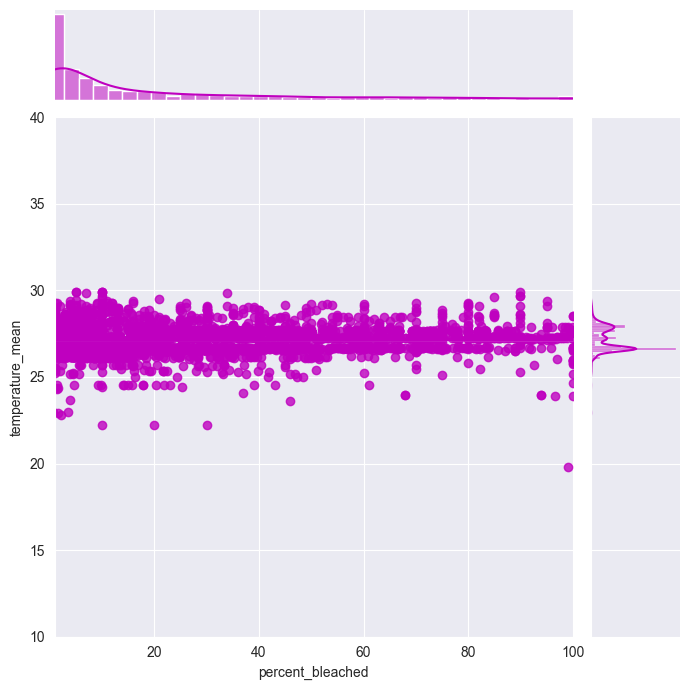

In [399]:
g = sns.jointplot(y="temperature_mean", x="percent_bleached", data=train_dataset,
                  kind="reg", truncate=False,
                  ylim=(10, 40), xlim=(1,100),
                  color="m", height=7)

### Plotting the correlation between outside temperature mean and the percentage of coral bleached, where more severe coral bleaching is a different color and a larger circle

/Users/spencerromberg/Repos/ocean_data/venv/lib/python3.9/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


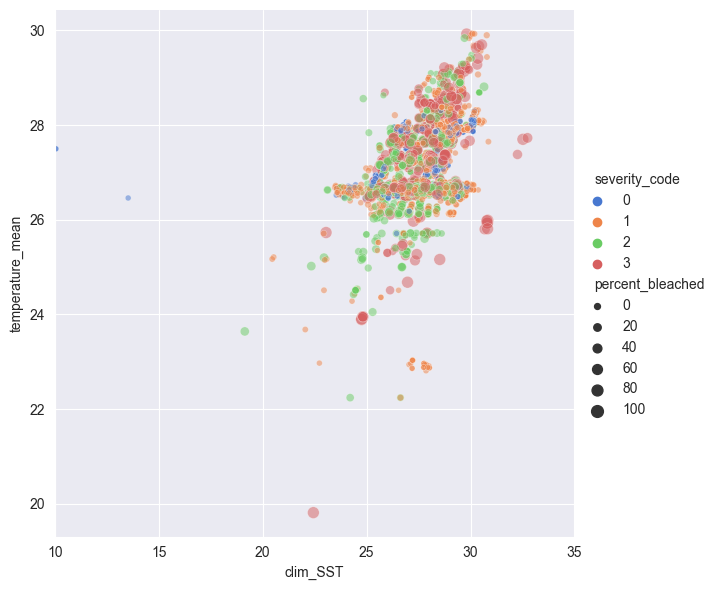

In [401]:
g = sns.relplot(x="clim_SST", y="temperature_mean", hue="severity_code", size="percent_bleached",
            alpha=.5, palette="muted",
            height=6, data=train_dataset)

g.set(xlim=(10, 35))


# Training the Model

## Using Percent Bleached as the input value

In [449]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('percent_bleached')
test_labels = test_features.pop('percent_bleached')

train_dataset.describe().transpose()
train_dataset.describe().transpose()[['mean', 'std']]
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())


[[2005.975    7.167   27.684   27.153    0.       3.576   -0.749    1.856
     1.392   18.79   -65.644]]


In [403]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())


First example: [[2007.     16.     27.97   26.55    0.      2.36    1.06    0.      2.  ]]

Normalized: [[ 0.21  1.6   0.11 -0.76  0.   -0.21  1.02 -0.36  0.66]]


In [404]:
clim_SST = np.array(train_features['clim_SST'])

clim_SST_normalizer = layers.Normalization(input_shape=[1,], axis=None)
clim_SST_normalizer.adapt(clim_SST)

clim_SST_model = tf.keras.Sequential([
    clim_SST_normalizer,
    layers.Dense(units=1)
])

clim_SST_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_9 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [405]:
clim_SST_model.predict(clim_SST[:10])


1/1 [==============================] - 0s 45ms/step


array([[-0.09 ],
       [ 0.077],
       [ 0.358],
       [-0.078],
       [-0.024],
       [-0.194],
       [-0.03 ],
       [ 0.235],
       [-0.109],
       [-0.415]], dtype=float32)

In [406]:
clim_SST_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [407]:
%%time
history = clim_SST_model.fit(
    train_features['clim_SST'],
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: user 21.1 s, sys: 2.47 s, total: 23.6 s
Wall time: 18.4 s


In [408]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()


,loss,val_loss,epoch
95,16.451494,16.166250,95
96,16.457739,16.173435,96
97,16.453131,16.166613,97
98,16.451181,16.172424,98
99,16.457115,16.162575,99


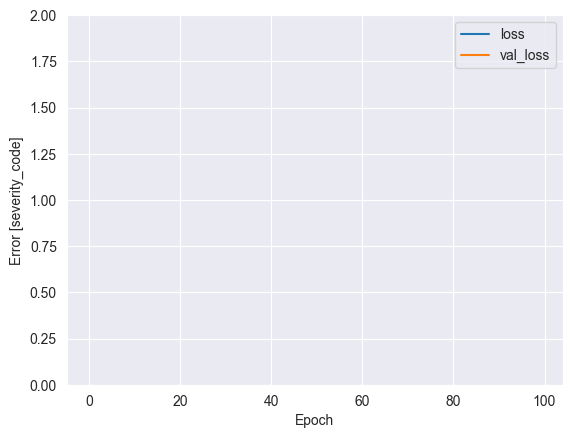

In [409]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [percent_bleached]')
  plt.legend()
  plt.grid(True)
plot_loss(history)


In [410]:
test_results = {}

test_results['clim_SST_model'] = clim_SST_model.evaluate(
    test_features['clim_SST'],
    test_labels, verbose=0)
x = tf.linspace(0.0, 250, 251)
y = clim_SST_model.predict(x)


8/8 [==============================] - 0s 2ms/step


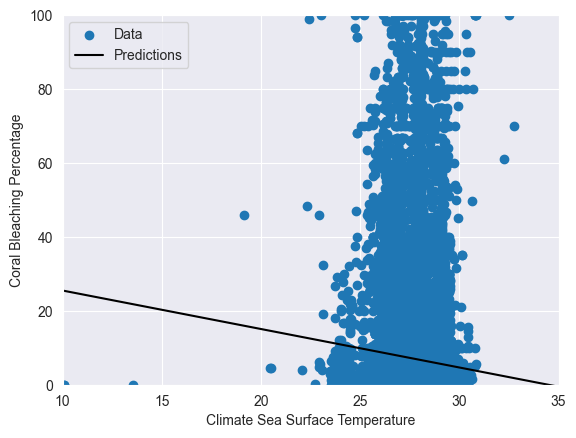

In [412]:
def plot_clim_SST(x, y):
  plt.scatter(train_features['clim_SST'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Climate Sea Surface Temperature')
  plt.ylabel('Coral Bleaching Percentage')
  plt.xlim([10, 35])
  plt.ylim([0, 100])
  plt.legend()
plot_clim_SST(x, y)


## Using Temp as the input

In [413]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('clim_SST')
test_labels = test_features.pop('clim_SST')

train_dataset.describe().transpose()
train_dataset.describe().transpose()[['mean', 'std']]
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())



[[2005.975   18.543    7.167   27.153    0.       3.576   -0.749    1.856
     1.392]]


In [414]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

percent_bleached = np.array(train_features['percent_bleached'])

percent_bleached_normalizer = layers.Normalization(input_shape=[1,], axis=None)
percent_bleached_normalizer.adapt(percent_bleached)

percent_bleached_model = tf.keras.Sequential([
    percent_bleached_normalizer,
    layers.Dense(units=1)
])

percent_bleached_model.summary()

First example: [[2007.     46.67   16.     26.55    0.      2.36    1.06    0.      2.  ]]

Normalized: [[ 0.21  1.15  1.6  -0.76  0.   -0.21  1.02 -0.36  0.66]]
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_11 (Normaliz  (None, 1)                 3         
 ation)                                                          
                                                                 
 dense_2 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


In [415]:
percent_bleached_model.predict(percent_bleached[:10])

1/1 [==============================] - 0s 44ms/step


array([[ 1.509],
       [-0.149],
       [ 0.296],
       [-0.727],
       [-0.957],
       [-0.494],
       [-0.724],
       [ 1.241],
       [ 3.136],
       [ 1.151]], dtype=float32)

In [418]:
percent_bleached_model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
  loss='mean_absolute_error')

In [419]:

%%time
history = percent_bleached_model.fit(
  train_features['percent_bleached'],
  train_labels,
  epochs=100,
  # Suppress logging.
  verbose=0,
  # Calculate validation results on 20% of the training data.
  validation_split=0.2)

CPU times: user 19.7 s, sys: 2.25 s, total: 21.9 s
Wall time: 17.4 s


In [420]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,1.222125,1.170032,95
96,1.220091,1.180440,96
97,1.224048,1.177942,97
98,1.226569,1.170677,98
99,1.222490,1.173416,99


8/8 [==============================] - 0s 948us/step


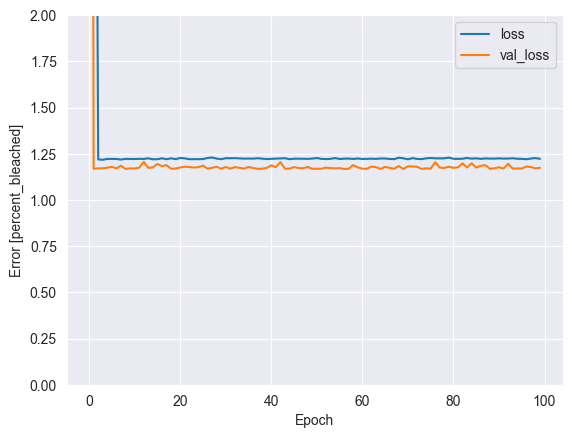

In [421]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error [percent_bleached]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

test_results = {}

test_results['percent_bleached_model'] = percent_bleached_model.evaluate(
    test_features['percent_bleached'],
    test_labels, verbose=0)
x = tf.linspace(0.0, 250, 251)
y = percent_bleached_model.predict(x)

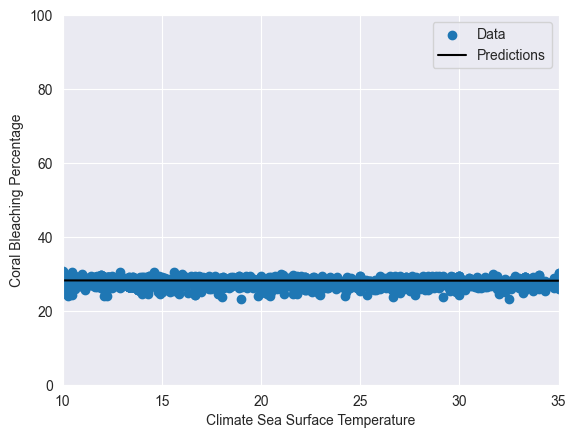

In [422]:
def plot_percent_bleached(x, y):
  plt.scatter(train_features['percent_bleached'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('Climate Sea Surface Temperature')
  plt.ylabel('Coral Bleaching Percentage')
  plt.xlim([10, 35])
  plt.ylim([0, 100])
  plt.legend()
plot_percent_bleached(x, y)

## Training on multiple inputs

In [450]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('percent_bleached')
test_labels = test_features.pop('percent_bleached')

train_dataset.describe().transpose()
train_dataset.describe().transpose()[['mean', 'std']]
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))
print(normalizer.mean.numpy())

[[2005.975    7.167   27.684   27.153    0.       3.576   -0.749    1.856
     1.392   18.79   -65.644]]


In [451]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

In [452]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')


In [453]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    # Suppress logging.
    verbose=0,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2)


CPU times: user 20.2 s, sys: 2.29 s, total: 22.5 s
Wall time: 17.1 s


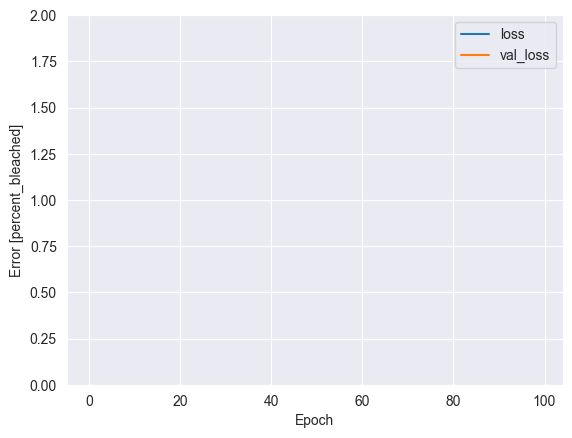

In [454]:
plot_loss(history)

In [486]:
prediction = linear_model.predict(train_features[:10][:10])
prediction

1/1 [==============================] - 0s 19ms/step


array([[24.436],
       [26.207],
       [26.451],
       [ 9.016],
       [ 7.838],
       [ 6.708],
       [ 5.687],
       [26.403],
       [49.62 ],
       [19.281]], dtype=float32)

In [ ]:
train_features[:10]

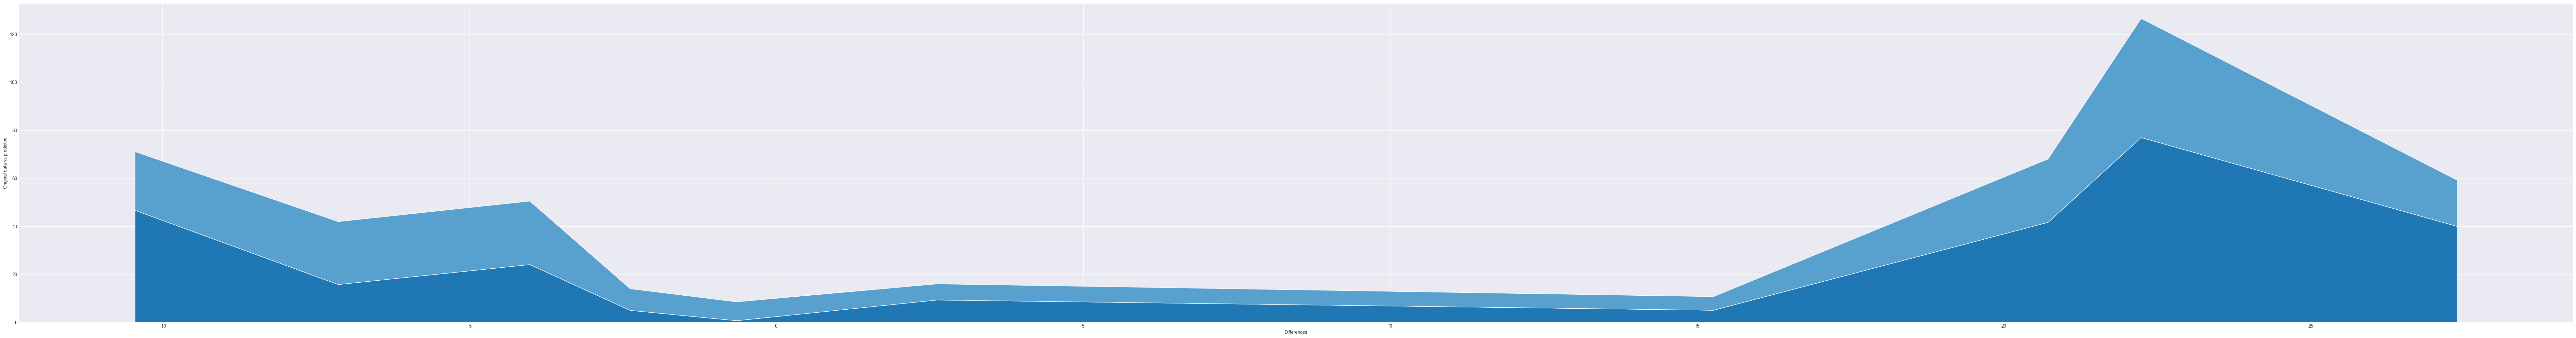

[-10.447472,
 -7.1376705,
 -4.015786,
 -2.3814163,
 -0.6471472,
 2.621791,
 15.266819,
 20.718868,
 22.2342,
 27.38049]

In [587]:
differences = []
for idx, x in enumerate(train_labels[:10].array):
  differences.append((train_labels[:10].array[idx] - prediction[idx])[0])
  
plt.style.use('_mpl-gallery')
original_data = np.expand_dims(train_labels[:10].array, axis=1)
y = np.vstack([train_labels[:10].array, prediction.flatten(), differences])
differences.sort()
plt.figure(figsize=(80, 10)
plt.stackplot(differences, train_labels[:10].array, prediction.flatten())
plt.xlabel('Differences')
plt.ylabel('Original data vs predicted')
plt.show()
differences